In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

2023-10-02 15:36:31.836483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 15:36:31.970922: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 15:36:32.834896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text): 
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first = True)

In [5]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

batch_size = 128 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                                                                      (train_data, valid_data, test_data),
                                                                      batch_size = batch_size,
                                                                      sort_within_batch = True,
                                                                      sort_key = lambda x:len(x.src),
                                                                      device = device
                                                                     )

### BUILDING THE MODEL

### Encoder 

In [13]:
# It will gets two context Vectors for each token in the input, if in put is 1 token, we would get 2 context, two for each

# The two context Vectors per token are a CONVED vector and a combined vector,

class Encoder(nn.Module):
    def __init__(
        self,
        input_dim,
        emb_dim,
        hid_dim,
        n_layers,
        kernel_size,
        dropout,
        device,
        max_length = 100
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        
        self.device = device 
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        self.conv = nn.ModuleList([nn.Conv1d(
                                             in_channels = hid_dim, 
                                             out_channels = 2 * hid_dim,
                                             kernel_size = kernel_size,
                                             padding = (kernel_size - 1) // 2
                                            )
                                  for _ in range(n_layers)
                                  ])
        
        self.dropout = nn.Dropout(dropout)
        
        def forward(self, src): 
            batch_size = src.shape[0]
            src_len    = src.shape[1]
            
            print(batch_size)
            
            pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
            
            tok_embedded = self.tok_embedding(src)
            pos_embedded = self.pos_embedding(pos)
            
            embedded = self.dropout(tok_embedded + pos_embedded)
            
            conv_input = self.emb2hid(embedded)
            conv_input = conv_input.permute(0, 2, 1)
            
            for i, conv in enumerate(self.convs):
                conved = conv(self.dropout(conv_input))
                conved = F.glu(conved, dim = 1)
                conved = (conved + conv_input) * self.scale
                conv_input = conved
                
            conved = self.hid2emb(conved.permute(0, 2, 1))
            combined = (conved + embedded) * self.scale
            return conved, combined
            
        
        
        

### Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(
        self, 
        output_dim, 
        emb_dim, 
        hid_dim, 
        n_layers, 
        kernel_size, 
        dropout, 
        trg_pad_idx, 
        device,
        max_length = 100
    ):
        super().__init__()
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim, output_dim)
        self.convs = nn.ModuleList([nn.Conv1d(
                                              in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size
                                             )
                                    for _ in range(n_layers)
                                   ])
        self.dropout = nn.Dropout(dropout)
        
    def calculate_attention(
        self,
        embedded,
        conved, 
        encoder_converd,
        encoder_combined
    ):
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        combined = (conved_emb + embedded) * self.scale
        energy = torch.matmul(combined, encoder_converd.permute(0, 2, 1))
        attention = F.softmax(energy, dim = 2)
        
        attended_encoding = torch.matmul(attention, encoder_combined)
        attended_encoding = self.attn_emb2hid(attended_encoding)
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        return attention, attended_combined
    
    def forward(
        self,
        trg, 
        encoder_conved,
        encoder_combined
    ): 
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        embedded = self.dropout(tok_embedded + pos_embedded)
        conv_input = self.emb2hid(embedded)
        conv_input = conv_input.permute(0, 2, 1)
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            conv_input = self.dropout(conv_input)
            padding = torch.zeros(batch_size,
                                 hid_dim,
                                 self.kernel_size - 1
                                 ).fill_(self.trg_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            conved = conv(padded_conv_input)
            conved = F.glu(conved, dim = 1)
            attention, conved = self.calculate_attention(
                                                        embedded,
                                                        conved,
                                                        encoder_conved,
                                                        encoder_combined
                                                        )
            
            conved = (conved + conv_input) * self.scale
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))
        return output, attention
    
        
        
        
        

### Seq2Seq

In [15]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        encoder,
        decoder
    ): 
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 
        
    def forward(
        self, 
        src, 
        trg
    ): 
        encoder_conved, encoder_combined = self.encoder(src)
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        return output, attention


### TRAINING STATE

In [16]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined
    



In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, 
              EMB_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_KERNEL_SIZE, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              EMB_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_KERNEL_SIZE,
              DEC_DROPOUT, 
              TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The model has 37,351,173 trainable parameters


In [19]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 15s
	Train Loss: 4.749 | Train PPL: 115.421
	 Val. Loss: 3.608 |  Val. PPL:  36.876
Epoch: 02 | Time: 0m 15s
	Train Loss: 3.442 | Train PPL:  31.256
	 Val. Loss: 2.701 |  Val. PPL:  14.888
Epoch: 03 | Time: 0m 15s
	Train Loss: 2.829 | Train PPL:  16.936
	 Val. Loss: 2.316 |  Val. PPL:  10.130
Epoch: 04 | Time: 0m 15s
	Train Loss: 2.506 | Train PPL:  12.255
	 Val. Loss: 2.103 |  Val. PPL:   8.190
Epoch: 05 | Time: 0m 14s
	Train Loss: 2.295 | Train PPL:   9.921
	 Val. Loss: 1.991 |  Val. PPL:   7.325
Epoch: 06 | Time: 0m 15s
	Train Loss: 2.140 | Train PPL:   8.502
	 Val. Loss: 1.900 |  Val. PPL:   6.685
Epoch: 07 | Time: 0m 14s
	Train Loss: 2.026 | Train PPL:   7.584
	 Val. Loss: 1.845 |  Val. PPL:   6.331
Epoch: 08 | Time: 0m 14s
	Train Loss: 1.925 | Train PPL:   6.858
	 Val. Loss: 1.794 |  Val. PPL:   6.011
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.849 | Train PPL:   6.352
	 Val. Loss: 1.761 |  Val. PPL:   5.821
Epoch: 10 | Time: 0m 15s
	Train Loss: 1.778 | Train PPL

In [2]:
!nvidia-smi

Mon Oct  2 15:36:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   33C    P0    36W / 250W |  15452MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
model.load_state_dict(torch.load('tut5-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.796 | Test PPL:   6.023 |


In [23]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attention



def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [24]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']
predicted trg = ['a', 'little', 'girl', 'climbs', 'in', 'a', 'playhouse', 'of', 'wood', '.', '<eos>']


/tmp/ipykernel_30208/3490185608.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_30208/3490185608.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


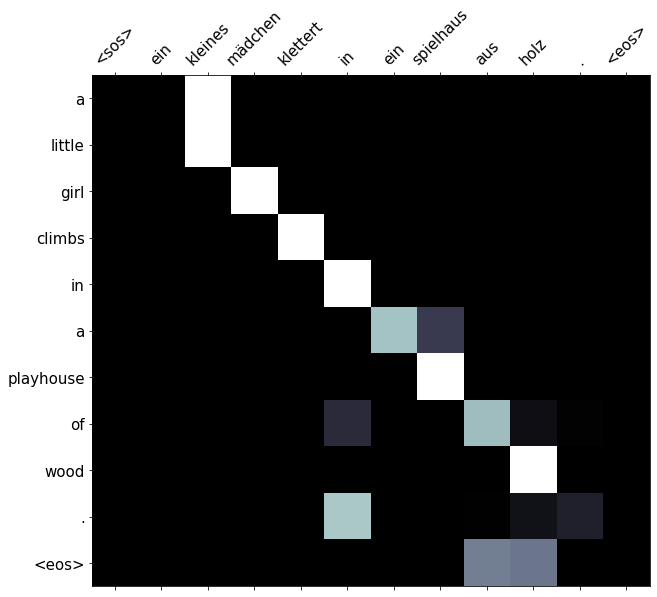

In [25]:
display_attention(src, translation, attention)

In [26]:
example_idx = 50

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['ein', 'junge', 'in', 'einer', 'roten', 'jacke', ',', 'der', 'wasser', 'auf', 'einen', 'mann', 'in', 'einem', 'weißen', 'hemd', 'gießt', '.']
trg = ['a', 'boy', 'in', 'a', 'red', 'jacket', 'pouring', 'water', 'on', 'a', 'man', 'in', 'a', 'white', 'shirt']
predicted trg = ['a', 'boy', 'in', 'a', 'red', 'jacket', 'pouring', 'water', 'on', 'a', 'man', 'in', 'a', 'white', 'shirt', '.', '<eos>']


/tmp/ipykernel_30208/3490185608.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_30208/3490185608.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


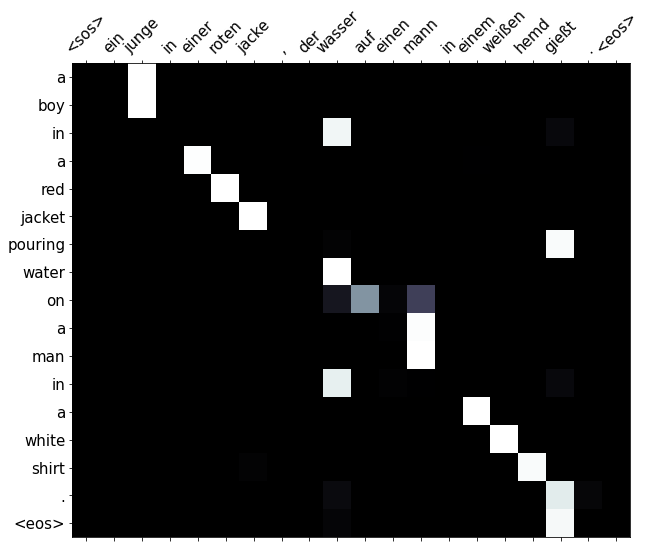

In [27]:
display_attention(src, translation, attention)

In [28]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    return bleu_score(pred_trgs, trgs)


bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.13
